In [10]:
# Instalación de dependencias
!py -m pip install -r ../requirements.txt

In [11]:
# Librerías básicas
import pandas as pd
import numpy as np
from random import randint


from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Reglas de asociación

# Clustering jerárquico



from mlxtend.frequent_patterns import apriori, association_rules

import re

In [12]:
# Cargado del dataset `Calidad_del_agua_del_Rio_Cauca_20240919`
REMOTE_ROUTE: str = "https://www.datos.gov.co/resource/d3ft-wu2b.csv"
LIMIT = 1000  # Límite de filas por solicitud
OFFSET = 0  # Offset inicial
dataframe: pd.DataFrame = pd.DataFrame()

try:
    from google.colab import drive
    %matplotlib inline
    #drive.mount("/content/drive")

    while True:
        # Construimos la URL con los parámetros limit y offset
        query_url = f"{REMOTE_ROUTE}?$limit={LIMIT}&$offset={OFFSET}"
        # Descargamos los datos
        df_chunk = pd.read_csv(query_url)
        # Si no hay más datos, rompemos el bucle
        if df_chunk.empty:
            break
        # Concatenamos los datos descargados
        dataframe = pd.concat([dataframe, df_chunk], ignore_index=True)
        # Incrementamos el offset
        OFFSET += LIMIT

except ImportError as e:
    print(f"We are not in a Google Colab environment ({e}), we will use a local route.")
    try:
        # Si están precargados cargamos los datos directamente
        dataframe = pd.read_csv("./sample_data/local_data.csv")
    except FileNotFoundError:
        while True:
            # Construimos la URL con los parámetros limit y offset
            query_url = f"{REMOTE_ROUTE}?$limit={LIMIT}&$offset={OFFSET}"
            # Descargamos los datos
            df_chunk = pd.read_csv(query_url)
            # Si no hay más datos, rompemos el bucle
            if df_chunk.empty:
                break
            # Concatenamos los datos descargados
            dataframe = pd.concat([dataframe, df_chunk], ignore_index=True)
            # Incrementamos el offset
            OFFSET += LIMIT
            # Guardamos una copia local
            dataframe.to_csv("./sample_data/local_data.csv", index=False)

# Mostramos las primeras filas
dataframe.shape
dataframe.head()


We are not in a Google Colab environment (No module named 'google'), we will use a local route.


,fecha_de_muestreo,estaciones,ph,temperatura_c,color_upc,turbiedad_unt,solidos_totales_mg_sst_l,solidos_suspendidos_totales,solidos_disueltos_mg_sd_l,demanda_bioquimica_de_oxigeno,...,cromo_total_mg_cr_l,cromo_disuelto_mg_cr_l_,niquel_total_mg_ni_l,niquel_disuelto_mg_ni_l_,plomo_total_mg_pb_l,plomo_disuelto_mg_pb_l_,mercurio_g_hg_l_,coliformes_totales_nmp_100,coliformes_fecales_nmp_100,caudal_m3_s
0,1998-12-19T00:00:00.000,YOTOCO,7.1,4.1,NaN,4.1,NaN,110.0,NaN,4.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-12-19T00:00:00.000,MEDIACANOA,7.0,2,NaN,2.0,NaN,130.0,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1998-12-19T00:00:00.000,PASO DE LA TORRE,7.0,22.9,NaN,3.4,NaN,153.3,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-05-09T00:00:00.000,ANTES SUAREZ,6.6,NaN,NaN,NaN,157.0,29.3,127.7,0.5,...,NaN,NaN,0,NaN,NaN,NaN,NaN,2.4*10E4,23,NaN
4,1990-01-10T00:00:00.000,ANTES RIO OVEJAS,6.7,NaN,NaN,NaN,143.0,65.0,78.0,2.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4*10E4,24*10E4,NaN


In [13]:
# Creación de enumerables para seleccionar los nombres de las columnas
class Data:
    FECHA_DE_MUESTREO = "fecha_de_muestreo"
    ESTACIONES = "estaciones"
    PH = "ph"
    TEMPERATURA_C = "temperatura_c"
    COLOR_UPC = "color_upc"
    TURBIEDAD_UNT = "turbiedad_unt"
    SOLIDOS_TOTALES_MG_SST_L = "solidos_totales_mg_sst_l"
    SOLIDOS_SUSPENDIDOS_TOTALES = "solidos_suspendidos_totales"
    SOLIDOS_DISUELTOS_MG_SD_L = "solidos_disueltos_mg_sd_l"
    DEMANDA_BIOQUIMICA_DE_OXIGENO = "demanda_bioquimica_de_oxigeno"
    DEMANDA_QUIMICA_DE_OXIGENO = "demanda_quimica_de_oxigeno"
    OXIGENO_DISUELTO_MG_O2_L = "oxigeno_disuelto_mg_o2_l"
    DUREZA_TOTAL_MG_CACO3_L = "dureza_total_mg_caco3_l"
    DUREZA_CALCICA_MG_CACO3_L = "dureza_calcica_mg_caco3_l"
    DUREZA_MAGNESICA_MG_CACO3 = "dureza_magnesica_mg_caco3"
    CALCIO_MG_CA_L = "calcio_mg_ca_l"
    MAGNESIO_MG_MG_L = "magnesio_mg_mg_l"
    ALCALINIDAD_TOTAL_MG_CACO3 = "alcalinidad_total_mg_caco3"
    BICARBONATOS_MG_CACO3_L = "bicarbonatos_mg_caco3_l"
    CONDUCTIVIDAD_EL_CTRICA_S = "conductividad_el_ctrica_s"
    HIERRO_TOTAL_MG_FE_L = "hierro_total_mg_fe_l"
    HIERRO_DISUELTO_MG_FE_L_ = "hierro_disuelto_mg_fe_l_"
    MANGANESO_TOTAL_MG_MN_L = "manganeso_total_mg_mn_l"
    MANGANESO_DISUELTO_MG_MN_L_ = "manganeso_disuelto_mg_mn_l_"
    SODIO_TOTAL_MG_NA_L = "sodio_total_mg_na_l"
    SODIO_DISUELTO_MG_NA_L_ = "sodio_disuelto_mg_na_l_"
    POTASIO_TOTAL_MG_K_L = "potasio_total_mg_k_l"
    POTASIO_DISUELTO_MG_K_L_ = "potasio_disuelto_mg_k_l_"
    COBRE_TOTAL_MG_CU_L = "cobre_total_mg_cu_l"
    COBRE_DISUELTO_MG_CU_L_ = "cobre_disuelto_mg_cu_l_"
    ZINC_TOTAL_MG_ZN_L = "zinc_total_mg_zn_l"
    ZINC_DISUELTO_MG_ZN_L_ = "zinc_disuelto_mg_zn_l_"
    CIANUROS_G_CN_L_ = "cianuros_g_cn_l_"
    FLUORUROS_MG_F_L_ = "fluoruros_mg_f_l_"
    SULFUROS_MG_S_2_L_ = "sulfuros_mg_s_2_l_"
    SILICE_MG_SI_L_ = "silice_mg_si_l_"
    NITROGENO_TOTAL_MG_N_L = "nitrogeno_total_mg_n_l"
    NITROGENO_AMONIACAL_MG_N = "nitrogeno_amoniacal_mg_n"
    NITRITOS_MG_N_NO2_L = "nitritos_mg_n_no2_l"
    NITRATOS_MG_N_NO3_L = "nitratos_mg_n_no3_l"
    CLORUROS_MG_CL_L = "cloruros_mg_cl_l"
    FOSFORO_TOTAL_MG_P_L = "fosforo_total_mg_p_l"
    FOSFATOS_MG_PO4_L = "fosfatos_mg_po4_l"
    SULFATOS_MG_SO4_L = "sulfatos_mg_so4_l"
    CADMIO_TOTAL_MG_CD_L = "cadmio_total_mg_cd_l"
    CADMIO_DISUELTO_MG_CD_L_ = "cadmio_disuelto_mg_cd_l_"
    CROMO_TOTAL_MG_CR_L = "cromo_total_mg_cr_l"
    CROMO_DISUELTO_MG_CR_L_ = "cromo_disuelto_mg_cr_l_"
    NIQUEL_TOTAL_MG_NI_L = "niquel_total_mg_ni_l"
    NIQUEL_DISUELTO_MG_NI_L_ = "niquel_disuelto_mg_ni_l_"
    PLOMO_TOTAL_MG_PB_L = "plomo_total_mg_pb_l"
    PLOMO_DISUELTO_MG_PB_L_ = "plomo_disuelto_mg_pb_l_"
    MERCURIO_G_HG_L_ = "mercurio_g_hg_l_"
    COLIFORMES_TOTALES_NMP_100 = "coliformes_totales_nmp_100"
    COLIFORMES_FECALES_NMP_100 = "coliformes_fecales_nmp_100"
    CAUDAL_M3_S = "caudal_m3_s"
    CONTAMINACION_METALICA = "contaminacion_metalica"


In [14]:
# Función para limpiar y convertir a numérico los valores de las columnas
def clean_and_convert(value):
    if pd.isna(value):
        return np.nan

    # Remover símbolos indeseados como '>', '<', '*', y cambiar comas por puntos
    value = str(value).replace('>', '').replace('<', '').replace('*', '').replace(',', '.')

    # Usar regex para identificar y manejar exponentes (como E, 10E)
    if re.search(r'[eE]', value):
        try:
            return float(value)
        except ValueError:
            return np.nan

    # Usar regex para manejar notación científica con el formato 'x*10^y'
    if re.search(r'\d+\.\d*\*10E[\+\-]?\d+', value):
        try:
            base, exponent = value.split('*10E')
            return float(base) * 10 ** float(exponent)
        except ValueError:
            return np.nan

    # Intentar convertir el valor directamente a float
    try:
        return float(value)
    except ValueError:
        return np.nan

In [15]:
# Seleccionamos todas las columnas numéricas
NUM_COLS = dataframe.iloc[:, 2:].columns

# Seleccionamos todas las columnas numéricas y las limpiamos
numeric: pd.DataFrame = dataframe[NUM_COLS].applymap(clean_and_convert)


# Eliminación de columnas con más del 50% de valores nulos y tratamiento de valores nulos
threshold = 0.5
numeric = numeric.loc[:, numeric.isnull().mean() < threshold]
numeric = numeric.fillna(numeric.mean())


full_dataframe = pd.concat([dataframe.iloc[:,:2], numeric], axis=1)
full_dataframe.describe()

C:\Users\overd\AppData\Local\Temp\ipykernel_6136\1507087721.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric: pd.DataFrame = dataframe[NUM_COLS].applymap(clean_and_convert)


,ph,temperatura_c,color_upc,turbiedad_unt,solidos_totales_mg_sst_l,solidos_suspendidos_totales,solidos_disueltos_mg_sd_l,demanda_bioquimica_de_oxigeno,demanda_quimica_de_oxigeno,oxigeno_disuelto_mg_o2_l,...,cloruros_mg_cl_l,fosforo_total_mg_p_l,fosfatos_mg_po4_l,sulfatos_mg_so4_l,cadmio_total_mg_cd_l,cromo_total_mg_cr_l,niquel_total_mg_ni_l,plomo_total_mg_pb_l,coliformes_totales_nmp_100,coliformes_fecales_nmp_100
count,2254.000000,2254.000000,2254.000000,2254.000000,2254.000000,2254.000000,2254.00000,2254.000000,2254.000000,2254.000000,...,2254.000000,2254.000000,2254.000000,2254.000000,2254.000000,2254.000000,2254.000000,2254.000000,2.254000e+03,2.254000e+03
mean,7.044717,22.022321,135.280069,134.044514,275.185570,161.363904,117.46440,5.006724,28.351104,4.061527,...,7.027014,0.268925,0.094475,18.368555,0.205591,0.165057,0.075543,0.148743,1.240005e+11,1.180217e+13
std,0.402512,3.355730,223.501644,172.613723,224.572612,201.345737,62.76937,15.676351,36.120875,2.938073,...,19.809453,0.804148,0.441219,16.436793,1.672273,0.112031,0.173481,0.158637,5.076992e+12,5.055274e+14
min,4.100000,0.000000,0.000000,1.000000,0.000000,1.200000,0.00000,0.100000,1.460000,0.000000,...,0.112000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,6.800000,21.000000,43.725000,32.000000,143.250000,39.000000,84.00000,1.940000,12.500000,2.320000,...,4.092500,0.093175,0.056200,14.200000,0.010000,0.043000,0.017725,0.060000,2.400000e+04,9.300000e+03
50%,7.060000,22.022321,80.750000,74.000000,209.000000,90.000000,109.00000,3.000000,19.700000,3.865000,...,5.970000,0.172000,0.064000,18.368555,0.040000,0.200000,0.090000,0.060000,2.400000e+05,9.300000e+04
75%,7.270000,24.000000,135.280069,147.000000,319.000000,210.000000,135.87500,4.747500,30.545000,5.600000,...,8.020000,0.268925,0.100000,20.700000,0.040000,0.288000,0.090000,0.310000,1.500000e+07,2.400000e+06
max,9.700000,32.700000,2956.000000,1900.000000,2361.000000,2112.000000,864.40000,427.000000,706.000000,51.500000,...,738.000000,14.180000,20.100000,696.800000,24.400000,0.997000,7.700000,1.540000,2.410000e+14,2.400000e+16


In [16]:
# ** Conversión de la columna de fechas (FECHA_DE_MUESTREO) **
full_dataframe[Data.FECHA_DE_MUESTREO] = pd.to_datetime(
    full_dataframe[Data.FECHA_DE_MUESTREO],
    errors="coerce",  # Convierte fechas inválidas a NaT
    infer_datetime_format=True,  # Infiere formatos mixtos
)

# ** Función para generar una fecha aleatoria en un año reciente (2022 o 2023) **
def generar_fecha_random():
    year = np.random.choice([2022, 2023])
    month = randint(1, 12)
    day = randint(1, 28)  # Evitar problemas con días fuera de rango
    hour = randint(0, 23)
    minute = randint(0, 59)
    return pd.Timestamp(year=year, month=month, day=day, hour=hour, minute=minute)

# ** Llenar las fechas 'NaT' con una fecha reciente aleatoria **
full_dataframe[Data.FECHA_DE_MUESTREO] = full_dataframe[Data.FECHA_DE_MUESTREO].apply(
    lambda x: generar_fecha_random() if pd.isna(x) else x
)

# ** Ordenar el DataFrame por la columna de fechas **
full_dataframe = full_dataframe.sort_values(by=Data.FECHA_DE_MUESTREO)

# Verificar la distribución después del reemplazo
print(full_dataframe[Data.FECHA_DE_MUESTREO].value_counts())

fecha_de_muestreo
2015-03-18 00:00:00    19
2017-05-09 00:00:00    19
2019-08-14 00:00:00    19
2019-06-18 00:00:00    19
2018-08-14 00:00:00    19
                       ..
2023-04-15 13:55:00     1
2023-06-21 15:30:00     1
2023-06-21 01:30:00     1
2023-05-03 04:47:00     1
2023-06-21 17:30:00     1
Name: count, Length: 210, dtype: int64


C:\Users\overd\AppData\Local\Temp\ipykernel_6136\1818644971.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  full_dataframe[Data.FECHA_DE_MUESTREO] = pd.to_datetime(


In [17]:
# ** Imputar la columna 'estaciones' **

# Calcular la moda (valor más frecuente) en la columna 'estaciones'
moda_estaciones = full_dataframe['estaciones'].mode()[0]

# Rellenar los valores NaN en 'estaciones' con la moda
full_dataframe['estaciones'].fillna(moda_estaciones, inplace=True)

# Verificar que ya no haya valores NaN en la columna 'estaciones'
print(full_dataframe['estaciones'].isna().sum())

0


C:\Users\overd\AppData\Local\Temp\ipykernel_6136\2772320851.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_dataframe['estaciones'].fillna(moda_estaciones, inplace=True)


# VARIABLE CATEGÓRICA

In [18]:
# Definir los metales relevantes
TARGET = Data.CONTAMINACION_METALICA
metales = [
    Data.HIERRO_TOTAL_MG_FE_L,
    Data.MANGANESO_TOTAL_MG_MN_L,
    Data.SODIO_TOTAL_MG_NA_L,
    Data.POTASIO_TOTAL_MG_K_L,
    Data.PLOMO_TOTAL_MG_PB_L,
    Data.CROMO_TOTAL_MG_CR_L,
    Data.CADMIO_TOTAL_MG_CD_L,
    Data.NIQUEL_TOTAL_MG_NI_L,
    Data.COBRE_TOTAL_MG_CU_L,
    Data.ZINC_TOTAL_MG_ZN_L,
]

# Filtrar las columnas que existen en tu DataFrame
metales_presentes = [metal for metal in metales if metal in numeric.columns]

# Calcular los percentiles para cada metal
percentiles = {}
for metal in metales_presentes:
    percentiles[metal] = {
        "25": numeric[metal].quantile(0.25),
        "50": numeric[metal].quantile(0.50),
        "75": numeric[metal].quantile(0.75),
        "90": numeric[metal].quantile(0.90),
    }


# Función para asignar puntuación a cada metal en una muestra
def puntuacion_metal(concentracion, metal):
    if np.isnan(concentracion):
        return 0  # O decide cómo manejar NaN
    if concentracion <= percentiles[metal]["25"]:
        return 1
    elif concentracion <= percentiles[metal]["50"]:
        return 2
    elif concentracion <= percentiles[metal]["75"]:
        return 3
    elif concentracion <= percentiles[metal]["90"]:
        return 4
    else:
        return 5


# Función para calcular la puntuación total y asignar categoría
def contaminacion_metales(row):
    total_puntuacion = 0
    for metal in metales_presentes:
        concentracion = row[metal]
        puntuacion = puntuacion_metal(concentracion, metal)
        total_puntuacion += puntuacion

    # Ajustar los valores de N1, N2, N3 y N4 según tus datos
    N1 = len(metales_presentes) * 1.5  # Por ejemplo
    N2 = len(metales_presentes) * 2.5
    N3 = len(metales_presentes) * 3.5
    N4 = len(metales_presentes) * 4.5

    if total_puntuacion <= N1:
        return "viable"
    elif total_puntuacion <= N2:
        return "bajo"
    elif total_puntuacion <= N3:
        return "medio"
    elif total_puntuacion <= N4:
        return "alto"
    else:
        return "inviable"

# ** Parte 1: Calcular la columna de contaminación metálica **

# Aplicar la función 'contaminacion_metales' al DataFrame
full_dataframe['contaminacion_metalica'] = numeric.apply(contaminacion_metales, axis=1)
numeric['contaminacion_metalica'] = numeric.apply(contaminacion_metales, axis=1)
# Mostrar un resumen de la clasificación
print(full_dataframe['contaminacion_metalica'].value_counts())




# ** Almacenar el DataFrame con la data procesada en 'clean_data.csv' **
full_dataframe.to_csv("./sample_data/clean_data.csv", index=False)


contaminacion_metalica
bajo      1159
medio      747
viable     287
alto        61
Name: count, dtype: int64


In [20]:
# # ** Características y objetivo **
# FEATURES = metales  # Variables predictoras (metales)
# TARGET = Data.CONTAMINACION_METALICA  # Asegúrate de que esta columna esté en tu dataframe

# # Crear una copia del DataFrame para trabajar
# df = full_dataframe_resampled.copy()

# # ** Separar características (X) y etiquetas (y) **
# X = df[FEATURES]  # Variables predictoras (metales)
# y = df[TARGET]  # Variable objetivo (categoría de contaminación)

# # ** Codificar las etiquetas como números si es necesario **
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # ** Dividir los datos en conjunto de entrenamiento y conjunto de prueba **
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y_encoded, test_size=0.3, random_state=42
# )

# # ** GridSearchCV para encontrar la mejor profundidad del árbol **
# # Definir los parámetros a buscar (en este caso, la profundidad del árbol)
# param_grid = {
#     "max_depth": range(3, 20)  # Rango de 3 a 20 niveles, ajusta si es necesario
# }

# # Configurar el clasificador con GridSearchCV (búsqueda de cuadrícula con validación cruzada)
# grid_search = GridSearchCV(
#     estimator=DecisionTreeClassifier(random_state=42),
#     param_grid=param_grid,
#     cv=5,  # Validación cruzada de 5 pliegues
#     scoring="accuracy",
# )  # Usar precisión como métrica

# # ** Entrenar el GridSearch para encontrar el mejor modelo **
# grid_search.fit(X_train, y_train)

# # ** Mostrar la mejor profundidad encontrada **
# print(
#     "Mejor profundidad del árbol encontrada por GridSearch:",
#     grid_search.best_params_["max_depth"],
# )

# # ** Entrenar el modelo con la mejor profundidad encontrada **
# best_clf = grid_search.best_estimator_

# # ** Hacer predicciones con el mejor modelo en el conjunto de prueba **
# y_pred_best = best_clf.predict(X_test)

# # ** Evaluar el rendimiento del modelo optimizado **
# accuracy_best = accuracy_score(y_test, y_pred_best)
# print("Precisión del modelo optimizado: {:.2f}%".format(accuracy_best * 100))

# # ** Matriz de confusión y reporte de clasificación para el modelo optimizado **
# print("\nMatriz de Confusión (Modelo Optimizado):")
# print(confusion_matrix(y_test, y_pred_best))
# print("\nInforme de Clasificación (Modelo Optimizado):")
# print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

# # ** Visualización del mejor árbol de decisión **
# plt.figure(figsize=(12, 8), dpi=1000)  # Incrementa el DPI para mejorar la calidad
# tree.plot_tree(
#     best_clf, feature_names=FEATURES, class_names=label_encoder.classes_, filled=True
# )
# plt.title("Árbol de Decisión Optimizado")
# plt.show()

Se encuentra cómo estos agentes metálicos contaminantes afectan a la calidad agua en Cauca, Colombia. Se tiene un conjunto de datos que contiene la concentración de los agentes metálicos contaminantes en el aire y la calidad del aire en la ciudad de Medellín, Colombia.

# SIN VARIABLE DE CLASE

Se logra determinar cómo a partir de patrones vistos en los el fósforo, fosfatos etc, se puede determinar a su vez la calidad del agua en el Rio Cauca, Colombia.

In [21]:
# smote = SMOTE(sampling_strategy='minority')
# X, y = smote.fit_resample(full_dataframe.drop('Clase', axis=1), full_dataframe['Clase'])

# # Escalado de los datos
# scaler = StandardScaler()
# # Crear un dataset de ejemplo con 2 características
# data = {
#     'Feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#     'Feature2': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# }

# #Se estructura el dataset como un dataframe para poder manipularlo
# full_dataframe = pd.DataFrame(data)

# # Mostrar los datos originales
# print("Datos originales:")
# print(full_dataframe)

# # Se estructura el KMeans para agrupar los datos en 2 clusters
# kmeans = KMeans(n_clusters=2, random_state=42)
# # Se ejecuta el KMEANS para segmentar los datos en 2 grupos
# # sobre el Dataframe original se almacena los resultados, agregando un nuevo atributo
# # el cual es el grupo clasificado por instancia
# full_dataframe['Cluster'] = kmeans.fit_predict(full_dataframe[['Feature1', 'Feature2']])

# # Mostrar los resultados
# print("\nDatos con Clusters:")
# print(full_dataframe)

# # Visualizar los clusters: Genera un modelo que describe

# #Se crea un grafico de dispersion, tomando como eje X y Y los atributos utilizados.
# # El parametro C son los colores, que seran por cada grupo del atributo cluster
# # CMAP: Plantilla de colores utilizados, pueden consultar mas en https://matplotlib.org/stable/users/explain/colors/colormaps.html
# #
# plt.scatter(full_dataframe['Feature1'], full_dataframe['Feature2'], c=full_dataframe['Cluster'], cmap='viridis')
# plt.title('Clustering con K-Means')
# plt.xlabel('Feature1')
# plt.ylabel('Feature2')
# plt.show()
# caler()
# X = scaler.fit_transform(X)

# # Entrenamiento del modelo
# model = DBSCAN(eps=0.5, min_samples=5)
# model.fit(X)

# # Visualización de los resultados
# plt.scatter(X[:, 0], X[:, 1], c=model.labels_)

# plt.xlabel('pH')
# plt.ylabel('Turbidez')
# plt.title('DBSCAN')
# plt.show()

Datos con Clusters asignados por DBSCAN:
    Feature1  Feature2  Cluster
0          1         1        0
1          2         2        0
2          3         3        0
3          8         8        0
4          9         9        0
5         10        10        0
6         25        25        0
7         26        26        0
8         27        27        0
9         50        50        1
10        55        55        1
11        60        60        1


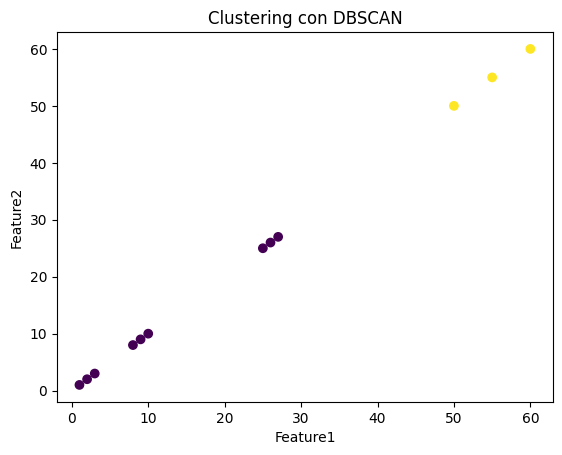

In [22]:
# Generación de clústering vía DBSCAN


# Crear un dataset de ejemplo con 2 características
data = {
    'Feature1': [1, 2, 3, 8, 9, 10, 25, 26, 27, 50, 55, 60],
    'Feature2': [1, 2, 3, 8, 9, 10, 25, 26, 27, 50, 55, 60]
}

#Estructuramos el dataset como un dataframe
dataframe = pd.DataFrame(data)

# Se estructuran los datos y se preparan para que sean analizados adecuadamente
#analizados por el algoritmo (numerizacion, normalizacion,etc.)

# Podemos aplicar una normalización (mirar categorías específicas que se ajusten más o menos a un rango), digamos  de un gurpo poblacional que se acomode a un rango, que se ajuste de numérico a categórico. Pero digamos tenemos textos que queremos volver numeritos, de forme que se pueden realizar interpretaciones, tener un valor numérico que está entre 0 y 1

# Para normalizar o estandarizar los datos depende del algoritmo, si son categoricos se pasan de numéricos a categóricos.

scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataframe[['Feature1', 'Feature2']])


#Epsilon: La distancia máxima entre dos muestras para que una se considere vecina de la otra

# Aplicar DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=2)  # eps (espsilon): tamaño del radio (por defecto es 0,5), min_samples: puntos mínimos para formar un cluster (si no es capaz de hacer la clusterización intenta hacer 2)
#Se ejecuta y los resultados se almacenan en el dataframe original en un nuevo atributo
dataframe['Cluster'] = dbscan.fit_predict(scaled_features)

# Mostrar los resultados
print("Datos con Clusters asignados por DBSCAN:")
print(dataframe)

# Visualizar los clusters
plt.scatter(dataframe['Feature1'], dataframe['Feature2'], c=dataframe['Cluster'], cmap='viridis')
plt.title('Clustering con DBSCAN')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.show()
